<a href="https://colab.research.google.com/github/connorhuis/SentimentAnalysisProj/blob/main/SentimentAnalysisProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis on Tweets From Twitter.com

[Dataset](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data)


In [1]:
%pip install contractions
import contractions
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import re
import numpy as np
import string
from plotly import graph_objs as go
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import HTML
from collections import Counter

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# ntlk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##Removing Duplicates and Null Records

In [2]:
train = pd.read_csv('/content/drive/MyDrive/twitter_training.csv')
test = pd.read_csv('/content/drive/MyDrive/twitter_validation.csv')
train.rename(columns = {'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Sentiment'
                        , "im getting on borderlands and i will murder you all ,": 'Text'},inplace = True)

In [3]:
# @title
print(train.isnull().sum(),'\n','Duplicates:',train.duplicated().sum()) # See how many null records in train
train.drop_duplicates(inplace = True)
train.dropna(inplace = True)
print(train.isnull().sum(),'\n','\n','Duplicates:',train.duplicated().sum()) # Drop null records

Index          0
Land           0
Sentiment      0
Text         686
dtype: int64 
 Duplicates: 2700
Index        0
Land         0
Sentiment    0
Text         0
dtype: int64 
 
 Duplicates: 0


In [4]:
unique_indices_mask = ~train['Index'].duplicated(keep='first')
trainU = train[unique_indices_mask]
trainU.describe()

,Index
count,12447.000000
mean,6432.586165
std,3740.553090
min,1.000000
25%,3195.500000
50%,6422.000000
75%,9600.500000
max,13200.000000


##Visualizing the Data

##Cleaning text

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

trainU['Text'] = trainU['Text'].apply(lambda x:clean_text(x))

<ipython-input-5-8489212b3950>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainU['Text'] = trainU['Text'].apply(lambda x:clean_text(x))


In [6]:
trainU['splitText'] = trainU['Text'].apply(lambda x:str(x).split())
trainU.reset_index(inplace=True)
trainU.drop('Index',axis = 1,inplace = True);
# trainU

<ipython-input-6-28f28b10c206>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainU['splitText'] = trainU['Text'].apply(lambda x:str(x).split())
<ipython-input-6-28f28b10c206>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainU.drop('Index',axis = 1,inplace = True);


Removing stop words is essential when doing sentiment analysis. Stop words are a set of commonly used words in a language. Obviously for this model we will remove words that NTLK defines as english stop words. Examples in the stop word corpus include I, Me, Yours, Will, and plenty of other words. We remove these in sentiment analysis because they provide a low level of information which the model will get 'bogged' down by and give less focus on more important information like the non stop words.

In [7]:
trainU['CleanText'] = None
stopW = set(stopwords.words('english'));

<ipython-input-7-7b4c9d5a96a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainU['CleanText'] = None


Lemmatizing or stemming the data is also an essential step in cleaning the data for sentiment analysis. For this data I choose to lemmatize it since it typically provides more context and meaning to the words rather than just stemming them. Stemming words refers to the reduction of a word to its stem without any prefixes or suffixes. This is usually done by a crude process of chopping off the ends of words in hope of getting close to the proper stem. Lemmatizing is basically the same but it instead uses a morphological analysis to accurately identify the 'lemma' for each word instead of a cruder method. This uses much more computer power, and in turn more computationally expensive for, most of the time, a modest increase in accuracy or recall.  

In [8]:
CT = pd.DataFrame()
CT['CleanText'] = None
wordLem = WordNetLemmatizer()
for i, x in enumerate(trainU['splitText']):
  clean = []
  for y in x:
    if y not in stopW and len(y) >= 2:
      lemma = wordLem.lemmatize(y)
      clean.append(lemma)
      clean = clean
  CT = CT.append({'CleanText': clean}, ignore_index=True);
  # print(clean)

Streaming output truncated to the last 5000 lines.
<ipython-input-8-667488d94f76>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CT = CT.append({'CleanText': clean}, ignore_index=True)
<ipython-input-8-667488d94f76>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CT = CT.append({'CleanText': clean}, ignore_index=True)
<ipython-input-8-667488d94f76>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CT = CT.append({'CleanText': clean}, ignore_index=True)
<ipython-input-8-667488d94f76>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CT = CT.append({'CleanText': clean}, ignore_index=True)
<ipython-input-8-667488d94f76>:11: FutureWarn

Further text cleaning for the new column

In [9]:
for i, x in enumerate(CT['CleanText']):
    x = str(x)
    x = contractions.fix(x)
    x = x.replace("'", '')
    x = x.replace(',', '')
    x = x.replace('[', '')
    x = x.replace(']', '')
    CT.at[i, 'CleanText'] = x

Translating English sentiment to binary code. If positive sentiment the text is tagged with a 1 and if negative a 0. The irrelevant and neutral comments are combined under 2.

In [10]:
mergedDF  = pd.merge(CT, trainU[['Sentiment']], left_index=True, right_index=True)
conditions = [
    (mergedDF['Sentiment'] == 'Positive'),
    (mergedDF['Sentiment'] == 'Negative'),
    (mergedDF['Sentiment'] == 'Neutral'),
    (mergedDF['Sentiment'] == 'Irrelevant')
]

values = [1, 0, 2, 2]

mergedDF['Sentiment_Label'] = np.select(conditions, values, default=0)
mergedDF.head(6)

,CleanText,Sentiment,Sentiment_Label
0,coming border kill,Positive,1
1,spent hour making something fun know huge bord...,Positive,1
2,rockhard la varlope rare powerful handsome jac...,Neutral,2
3,first borderland session long ti ame actually ...,Positive,1
4,biggest dissappoinment life came year ago fuck...,Negative,0
5,finished borderland finally yas thank hanging ...,Positive,1


Most common words showing in each category

In [11]:
# @title
Positive = mergedDF[mergedDF['Sentiment'] == 'Positive']
Negative = mergedDF[mergedDF['Sentiment'] == 'Negative']
Neutral = mergedDF[mergedDF['Sentiment'] == 'Neutral']
Irrelevant = mergedDF[mergedDF['Sentiment'] == 'Irrelevant']
temp_pos = Counter([word for sublist in Positive['CleanText'].str.split() for word in sublist])
temp_pos = pd.DataFrame(temp_pos.most_common(20))
temp_pos = temp_pos.iloc[1:, :]
temp_pos.columns = ['Positive Words', 'Count']

temp_neutral = Counter([word for sublist in Neutral['CleanText'].str.split() for word in sublist])
temp_neutral = pd.DataFrame(temp_neutral.most_common(20))
temp_neutral = temp_neutral.iloc[1:, :]
temp_neutral.columns = ['Neutral Word', 'Count']

temp_negative = Counter([word for sublist in Negative['CleanText'].str.split() for word in sublist])
temp_negative = pd.DataFrame(temp_negative.most_common(20))
temp_negative = temp_negative.iloc[1:, :]
temp_negative.columns = ['Negative Word', 'Count']
temp_negative.style.background_gradient(cmap='Greys')

temp_irrelevant = Counter([word for sublist in Irrelevant['CleanText'].str.split() for word in sublist])
temp_irrelevant = pd.DataFrame(temp_irrelevant.most_common(20))
temp_irrelevant = temp_irrelevant.iloc[1:, :]
temp_irrelevant.columns = ['Irrelevant Word', 'Count']
temp_irrelevant.style.background_gradient(cmap='Greys')

def add_background_gradient(df, cmap):
    return df.style.background_gradient(cmap=cmap)

# Apply background gradient to each DataFrame
styled_temp_pos = add_background_gradient(temp_pos, cmap='Greens')
styled_temp_neutral = add_background_gradient(temp_neutral, cmap='Greys')
styled_temp_negative = add_background_gradient(temp_negative, cmap='Reds')
styled_temp_irrelevant = add_background_gradient(temp_irrelevant, cmap='Greys')

def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

side_by_side(styled_temp_pos,  styled_temp_negative, styled_temp_neutral, styled_temp_irrelevant)

,Positive Words,Count
1,love,319
2,i,291
3,good,279
4,like,238
5,really,201
6,new,200
7,best,200
8,one,191
9,ti,191
10,play,186


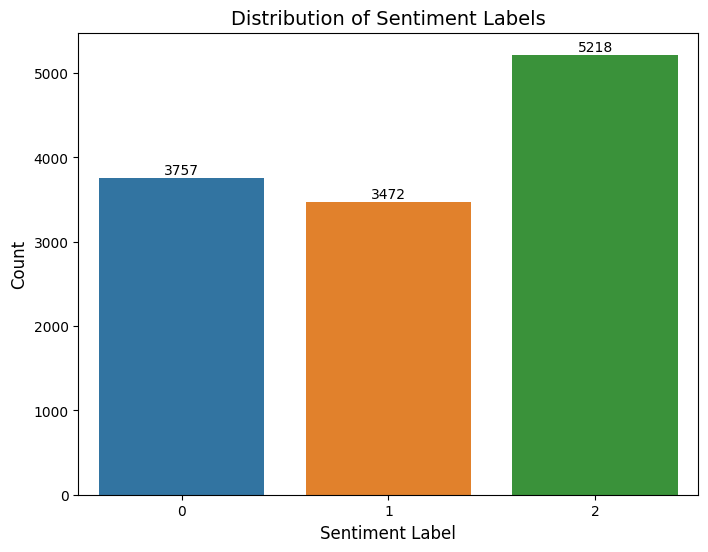

In [12]:
# @title
sentiment_counts = mergedDF['Sentiment_Label'].value_counts()
sentiment_counts = sentiment_counts.sort_index()

# Set a color palette for the plot
colors = sns.color_palette()

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)

# Customize labels and title
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Sentiment Labels', fontsize=14)

# Add annotations on top of the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

### Splitting the Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(mergedDF['CleanText'], mergedDF['Sentiment_Label'],
                                                    test_size = 0.1, random_state = 42)


### Vectorizing the Data

In [15]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), lowercase = True, max_features=500000)
vectoriserBi = TfidfVectorizer(ngram_range=(2,2), lowercase = True, max_features=500000)
vectoriserUni = TfidfVectorizer(ngram_range=(1,1), lowercase = True, max_features=500000)

vectoriser.fit(X_train)
X_trainV = vectoriser.transform(X_train)
X_testV = vectoriser.transform(X_test)

In [16]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), lowercase = True, max_features=500000)
vectoriserBi = TfidfVectorizer(ngram_range=(2,2), lowercase = True, max_features=500000)
vectoriserUni = TfidfVectorizer(ngram_range=(1,1), lowercase = True, max_features=500000)

vectoriser.fit(trainDF)
trainDFv = vectoriser.transform(trainDF)
testDFv = vectoriser.transform(testDF)

In [17]:
biDF = mergedDF[mergedDF['Sentiment_Label'].isin([1,0])]
X_trainBi, X_testBi, y_trainBi, y_testBi = train_test_split(biDF['CleanText'], biDF['Sentiment_Label'],
                                                    test_size = 0.1, random_state = 42)


vectoriser.fit(X_trainBi)
X_trainBiV = vectoriser.transform(X_trainBi)
X_testBiV = vectoriser.transform(X_testBi)

##SVC model

Sklearns Linear Support Vector Classification is a type of support vector machine used for classification and other things. LinearSVC is typically a faster implementation using a linear kernel. The SVC model will fit the data and return a 'best fit' hyperplane which will categorize the data.

In [18]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_trainV,y_train)
y_test_pred=clf.predict(X_testV)
from sklearn.metrics import classification_report
report=classification_report(y_test, y_test_pred,output_dict=True)
report

{'0': {'precision': 0.6285714285714286,
  'recall': 0.6534653465346535,
  'f1-score': 0.6407766990291262,
  'support': 404},
 '1': {'precision': 0.5779816513761468,
  'recall': 0.5526315789473685,
  'f1-score': 0.5650224215246636,
  'support': 342},
 '2': {'precision': 0.5923694779116466,
  'recall': 0.591182364729459,
  'f1-score': 0.5917753259779338,
  'support': 499},
 'accuracy': 0.6008032128514056,
 'macro avg': {'precision': 0.5996408526197406,
  'recall': 0.5990930967371603,
  'f1-score': 0.5991914821772412,
  'support': 1245},
 'weighted avg': {'precision': 0.6001646195914948,
  'recall': 0.6008032128514056,
  'f1-score': 0.6003271825158158,
  'support': 1245}}

SVC on binary dataset

In [19]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_trainBiV,y_trainBi)
y_test_pred=clf.predict(X_testBiV)
from sklearn.metrics import classification_report
report=classification_report(y_testBi, y_test_pred,output_dict=True)
report

{'0': {'precision': 0.84,
  'recall': 0.8615384615384616,
  'f1-score': 0.8506329113924052,
  'support': 390},
 '1': {'precision': 0.8328173374613003,
  'recall': 0.8078078078078078,
  'f1-score': 0.8201219512195123,
  'support': 333},
 'accuracy': 0.8367911479944675,
 'macro avg': {'precision': 0.8364086687306501,
  'recall': 0.8346731346731346,
  'f1-score': 0.8353774313059588,
  'support': 723},
 'weighted avg': {'precision': 0.8366918027311382,
  'recall': 0.8367911479944675,
  'f1-score': 0.8365801455036453,
  'support': 723}}

## Logistic Regression

In [20]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000,solver='saga')
clf.fit(X_trainV,y_train)
y_test_pred=clf.predict(X_testV)
from sklearn.metrics import classification_report
report=classification_report(y_test, y_test_pred,output_dict=True)
report

CPU times: user 472 ms, sys: 2.38 ms, total: 474 ms
Wall time: 474 ms


{'0': {'precision': 0.6563307493540051,
  'recall': 0.6287128712871287,
  'f1-score': 0.6422250316055624,
  'support': 404},
 '1': {'precision': 0.625,
  'recall': 0.5263157894736842,
  'f1-score': 0.5714285714285714,
  'support': 342},
 '2': {'precision': 0.5789473684210527,
  'recall': 0.6613226452905812,
  'f1-score': 0.6173994387277829,
  'support': 499},
 'accuracy': 0.6136546184738956,
 'macro avg': {'precision': 0.6200927059250193,
  'recall': 0.6054504353504647,
  'f1-score': 0.610351013920639,
  'support': 1245},
 'weighted avg': {'precision': 0.6167087225551191,
  'recall': 0.6136546184738956,
  'f1-score': 0.612827151905528,
  'support': 1245}}

Logistic regression on the binary dataset

In [21]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_trainBiV,y_trainBi)
y_test_pred=clf.predict(X_testBiV)
from sklearn.metrics import classification_report
report=classification_report(y_testBi, y_test_pred,output_dict=True)
report

CPU times: user 395 ms, sys: 518 ms, total: 913 ms
Wall time: 517 ms


{'0': {'precision': 0.8249400479616307,
  'recall': 0.882051282051282,
  'f1-score': 0.852540272614622,
  'support': 390},
 '1': {'precision': 0.8496732026143791,
  'recall': 0.7807807807807807,
  'f1-score': 0.8137715179968701,
  'support': 333},
 'accuracy': 0.8354080221300139,
 'macro avg': {'precision': 0.8373066252880048,
  'recall': 0.8314160314160314,
  'f1-score': 0.8331558953057461,
  'support': 723},
 'weighted avg': {'precision': 0.836331666909577,
  'recall': 0.8354080221300139,
  'f1-score': 0.8346841242222135,
  'support': 723}}

# BernoulliNB Model

BernoilluNB from scikit learn is a type of naïve bayes classifier. Naïve bayes model is a supervised machine learning algorithm which is used for text classification in this instance. SciKit BernoulliNB works with binary or Boolean features which is why we had to discard the irrelevant and neutral comments in the data. It does not learn which features are most important to differentiate unlike some other text classification models. It is a simple and fast model that provides good results that’s typically relatively easy to implement. The drawbacks are it usually makes mistakes when classifying long documents since it does not keep track of the number of occurrences. Because the BernoilliNB model only accepts binary input we have to cut our data down to only positive and negative sentiment.

Vectorizer Ngram Range = (1,2)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       390
           1       0.83      0.82      0.82       333

    accuracy                           0.84       723
   macro avg       0.84      0.84      0.84       723
weighted avg       0.84      0.84      0.84       723



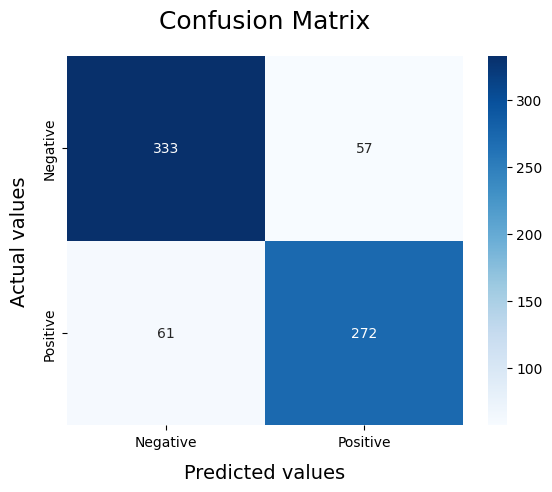

In [22]:
# @title
def model_Evaluate(model):


    y_pred = model.predict(X_testBiV) # Predict values for Test dataset

    print(classification_report(y_testBi, y_pred)) # Print the evaluation metrics for the dataset.

    cf_matrix = confusion_matrix(y_testBi, y_pred) # Compute and plot the Confusion matrix

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos',]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_trainBiV, y_trainBi)
model_Evaluate(BNBmodel)

Vectorizer Ngram Range = (2,2)

              precision    recall  f1-score   support

           0       0.63      0.91      0.74       390
           1       0.77      0.37      0.50       333

    accuracy                           0.66       723
   macro avg       0.70      0.64      0.62       723
weighted avg       0.69      0.66      0.63       723



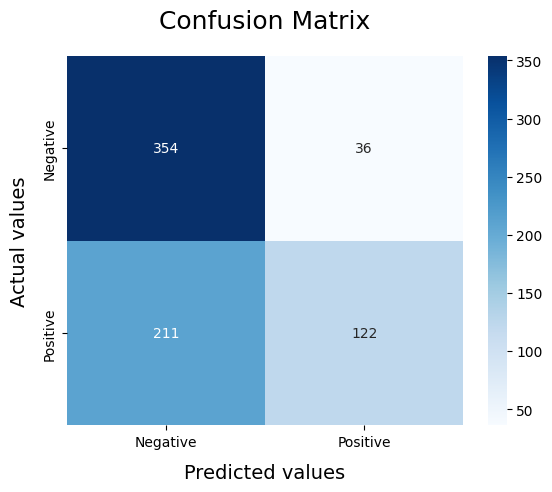

In [23]:
# @title
vectoriserBi.fit(X_trainBi)
X_trainBiVx2 = vectoriserBi.transform(X_trainBi)
X_testBiVx2 = vectoriserBi.transform(X_testBi)

def model_Evaluate(model):


    y_pred = model.predict(X_testBiVx2) # Predict values for Test dataset

    print(classification_report(y_testBi, y_pred)) # Print the evaluation metrics for the dataset.

    cf_matrix = confusion_matrix(y_testBi, y_pred) # Compute and plot the Confusion matrix

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos',]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_trainBiVx2, y_trainBi)
model_Evaluate(BNBmodel)

Vectorizer Ngram Range = (1,1)

              precision    recall  f1-score   support

           0       0.63      0.91      0.74       390
           1       0.77      0.37      0.50       333

    accuracy                           0.66       723
   macro avg       0.70      0.64      0.62       723
weighted avg       0.69      0.66      0.63       723



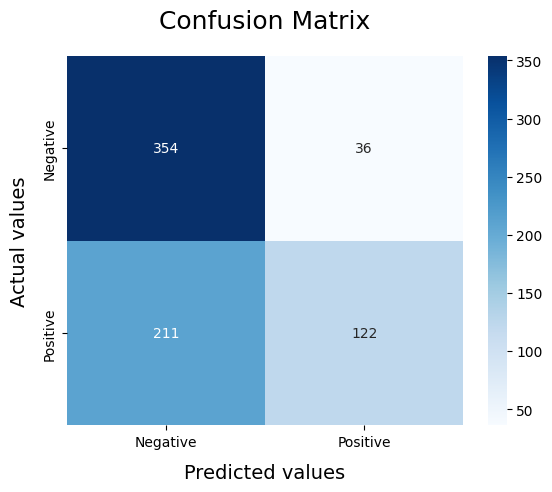

In [24]:
# @title
vectoriserUni.fit(X_trainBi)
X_trainBiVx1 = vectoriserBi.transform(X_trainBi)
X_testBiVx1 = vectoriserBi.transform(X_testBi)

def model_Evaluate(model):


    y_pred = model.predict(X_testBiVx1) # Predict values for Test dataset

    print(classification_report(y_testBi, y_pred)) # Print the evaluation metrics for the dataset.

    cf_matrix = confusion_matrix(y_testBi, y_pred) # Compute and plot the Confusion matrix

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos',]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_trainBiVx1, y_trainBi)
model_Evaluate(BNBmodel)